This vignette is part of the workshop: [Hands-on Tour of the Visium Spatial Gene Expression Analysis Journey](link).

We will begin by installing the necessary packages.

In [ ]:
install.packages("remotes")
install.packages("devtools")
system("apt install libgsl-dev", intern=TRUE)
devtools::install_github("paulponcet/lplyr")

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = '3.19',ask = FALSE)

BiocManager::install("clusterProfiler")
BiocManager::install("enrichplot")
BiocManager::install("ggplot2")
BiocManager::install("msigdbr")
BiocManager::install("dplyr")
BiocManager::install("DOSE")
BiocManager::install("forcats")
BiocManager::install("AnnotationDbi")
BiocManager::install("org.Hs.eg.db")

Next, load these required packages into the environment.

In [ ]:
library(clusterProfiler)
library(enrichplot)
library(ggplot2)
library(msigdbr)
library(dplyr)
library(lplyr)
library(DOSE)
library(forcats)
library(AnnotationDbi)
library(org.Hs.eg.db)

Read the in CSV file containing gene expression information and take a look at the dataframe

In [26]:
download.file("https://raw.githubusercontent.com/10XGenomics/analysis_guides/main/Visium_HD_GSEA/ROI_Features.csv", "ROI_Features.csv")
df <- read.csv("ROI_Features.csv", header = TRUE)
head(df)

,SYMBOL,Log2FC
,<chr>,<dbl>
1,COL1A2,5.897953
2,COL1A1,5.886694
3,SFRP4,6.789303
4,COL3A1,5.683523
5,COL11A1,7.466828
6,MMP2,5.869154


How many genes are in our list?

In [27]:
nrow(df)

[1] 18072

GSEA requires Entrez IDs as input. These are unique integer identifiers for genes from NCBI. We will use AnnotationDbi to find the IDs for each gene symbol in our list and take a look at the top of the data frame to see what it looks like.

In [28]:
entrez_data <- AnnotationDbi::select(org.Hs.eg.db, keys = df$SYMBOL,columns = c("SYMBOL", "ENTREZID"),keytype = "SYMBOL")
head(entrez_data)

'select()' returned many:many mapping between keys and columns



,SYMBOL,ENTREZID
,<chr>,<chr>
1,COL1A2,1278
2,COL1A1,1277
3,SFRP4,6424
4,COL3A1,1281
5,COL11A1,1301
6,MMP2,4313


Not every gene symbol has an associated Entrez ID. We will need to remove genes that do not have an Entrez ID ("NA") from our input list.

In [30]:
anno_result <- entrez_data %>%
  filter(!is.na(ENTREZID)) %>%
  inner_join(df, by = "SYMBOL",relationship = "many-to-many")

head(anno_result)

,SYMBOL,ENTREZID,Log2FC
,<chr>,<chr>,<dbl>
1,COL1A2,1278,5.897953
2,COL1A1,1277,5.886694
3,SFRP4,6424,6.789303
4,COL3A1,1281,5.683523
5,COL11A1,1301,7.466828
6,MMP2,4313,5.869154


How many genes remain after filtering NAs?

In [31]:
nrow(anno_result)

[1] 17635

The starting gene number was 18,072. So, we removed 437 or ~2% of our gene list due to NAs. This is not a large proportion of our gene list and so we will proceed assuming the list is still representative of our sample.

Next, we will turn this data frame into a named vector that has the Entrez ID and associated Log2FC information and sort it smallest Log2FC to largest.

In [32]:
geneList <- with(anno_result, setNames(Log2FC, ENTREZID))
geneList <- sort(geneList, decreasing = TRUE)

Next, we need to prepare our reference gene sets that we will use for analysis. There are a number of databases available to use. We chose to use a popular one, Gene Ontology: Molecular Function. We can access the gene sets in this database with the msigdbr package from MSigDB. To learn more about the gene sets available through this resource, go to this web page: https://www.gsea-msigdb.org/gsea/msigdb/human/collections.jsp

We find there is a database of computational gene sets defined by expression neighborhoods centered around cancer-associated genes. This database is relevant to our data, so we will use this one.

In [35]:
c4_t2g <- msigdbr(species = "Homo sapiens", category = "C4", subcategory = "CGN") %>%
  dplyr::select(gs_name, entrez_gene)
head(c4_t2g)

gs_name,entrez_gene
<chr>,<int>
CAR_HPX,13
CAR_HPX,130
CAR_HPX,173
CAR_HPX,183
CAR_HPX,6718
CAR_HPX,229


Now that we have our ranked gene list and gene set reference inputs, we can run GSEA.

In [36]:
c4 <- GSEA(geneList, TERM2GENE = c4_t2g)
c4

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (38.51% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 78 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minS

#
# Gene Set Enrichment Analysis
#
#...@organism 	 UNKNOWN 
#...@setType 	 UNKNOWN 
#...@geneList 	 Named num [1:17635] 7.75 7.47 6.97 6.92 6.83 ...
 - attr(*, "names")= chr [1:17635] "1311" "1301" "5270" "1118" ...
#...nPerm 	 
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...176 enriched terms found
'data.frame':	176 obs. of  11 variables:
 $ ID             : chr  "GNF2_PCNA" "GNF2_RFC4" "GNF2_MCM4" "GNF2_CCNA2" ...
 $ Description    : chr  "GNF2_PCNA" "GNF2_RFC4" "GNF2_MCM4" "GNF2_CCNA2" ...
 $ setSize        : int  64 57 52 65 35 59 59 37 57 60 ...
 $ enrichmentScore: num  -0.681 -0.692 -0.697 -0.674 -0.734 ...
 $ NES            : num  -3.14 -3.01 -3 -2.99 -2.99 ...
 $ pvalue         : num  1e-10 1e-10 1e-10 1e-10 1e-10 ...
 $ p.adjust       : num  1.39e-09 1.39e-09 1.39e-09 1.39e-09 1.39e-09 ...
 $ qvalue         : num  6.74e-10 6.74e-10 6.74e-10 6.74e-10 6.74e-10 ...
 $ rank           : num  4184 4410 4379 5106 3111 ...
 $ leading_edge   : chr  "tags=75%, list=24%, signal=57%"

The gene information is stored as Entrez ID, so we need to add the gene symbols into the c4 object to be able to interpret the results better. We will also put our results into a dataframe so they are easier to navigate.

In [37]:
c4 <- setReadable(c4, 'org.Hs.eg.db', 'ENTREZID')
c4_df <- c4@result

Our analysis is complete and stored in an object we called “c4”. There were ~170-180 enriched terms found in our data. Results may vary slightly due to random seeding.

We can use the object storing the results to generate some plots of our results. First, we will take a look at the overall summary results. We can visualize the top 10 gene sets that were up-regulated (activated in microenvironment), meaning these gene sets were enriched at the top of our list, where up-regulated genes were located. And we will also visualize the top 10 gene sets that were down-regulated (suppressed in microenvironment), meaning these gene sets were enriched at the bottom of our list, where down-regulated genes were located.

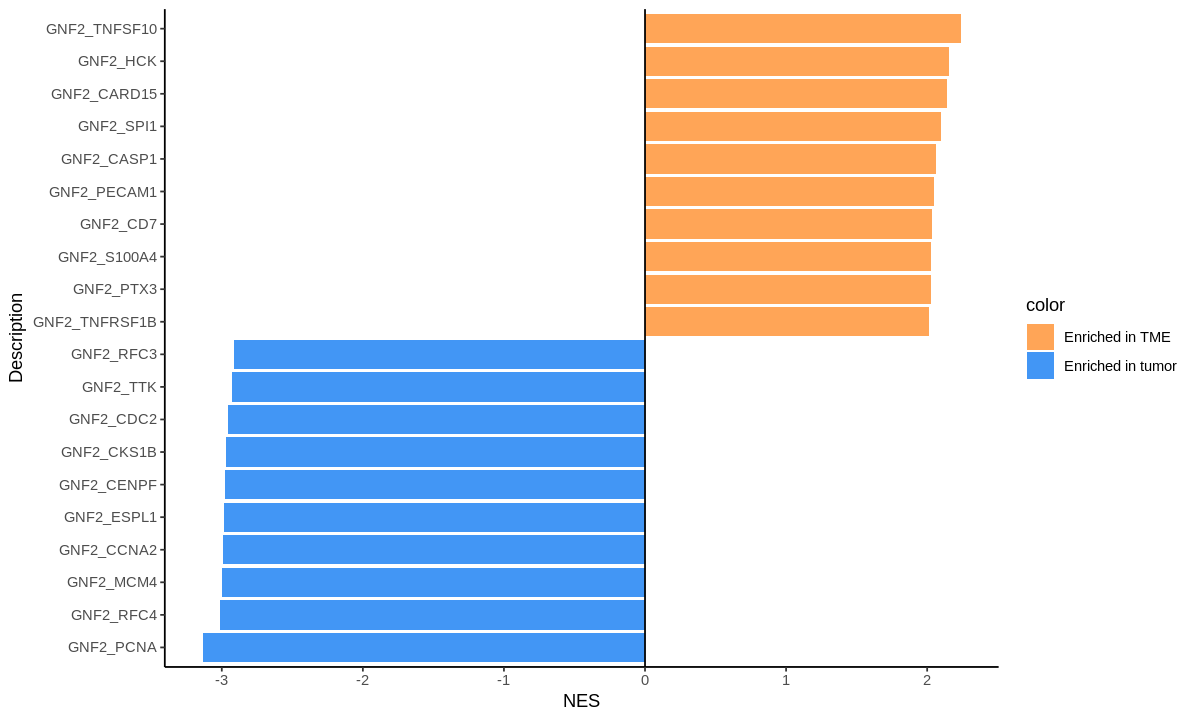

In [38]:
#set plot size
options(repr.plot.width=10, repr.plot.height=6)

#sort data and assign to "activated" or "suppressed" groups based on NES
sorted_c4<- c4@result[order(c4@result$NES, decreasing = F),]
sorted_c4$color<-ifelse(sorted_c4$NES<0, "Enriched in tumor", "Enriched in TME")

#plot results
sorted_c4 %>%
  dplyr::group_by(color) %>%
  dplyr::arrange(desc(abs(NES))) %>%
  slice_head(n = 10) %>%
  ggplot(aes(x = NES, y = reorder(Description, NES), fill = color)) +
  geom_bar(stat = "identity") +
  geom_vline(xintercept = 0) +
  labs(y = "Description") +
  theme_classic() +
  scale_fill_manual(values=c("#ffa557", "#4296f5")) +
  theme(legend.position = "right")

#save a publicaiton-quality version of the plot
ggsave("go_barplot.pdf",
        dpi = 600,
        width = 30, height = 15, unit = "cm")

Next, we can select one of these gene sets to explore more in-depth.


The database we are using organizes the gene pathways into sets of genes centered around known cancer-related genes. We will need to make use of the GSEA website to understand what each gene set is.

For example, looking into one of the modules enriched in the microenvironment region, [GNF2_PECAM1](https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/GNF2_PECAM1.html), we can learn more about it. First, we can take a look at the full list of genes in this gene set.

Based on the literature, we may find promising cancer treatment targets by looking at the genes in this gene set. We can generate a GSEA plot and a cnet plot for this module to evaluate the full set of genes in our data:

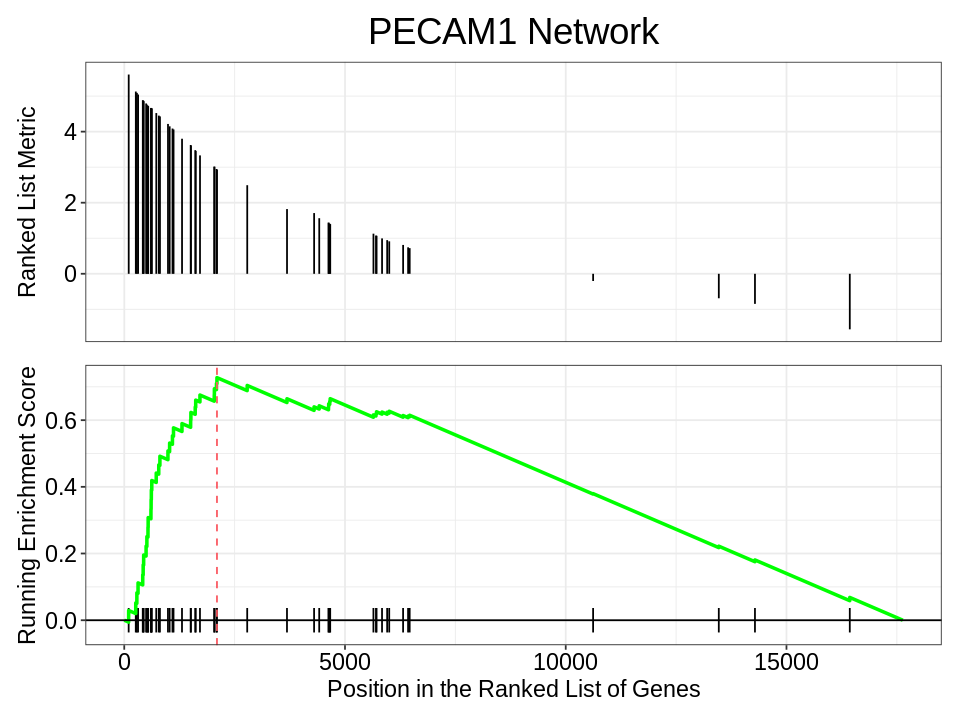

In [39]:
#re-set plot size
options(repr.plot.width=8, repr.plot.height=6)

#gsea plot
gseaplot(c4, by = "all", title = "PECAM1 Network", geneSetID = "GNF2_PECAM1")

And pull out the NES and adjusted p-value associated with this enriched set.

In [43]:
c4_df["GNF2_PECAM1",]

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GNF2_PECAM1,GNF2_PECAM1,GNF2_PECAM1,53,0.7274732,2.045654,3.01831e-10,3.475536e-09,1.686898e-09,2100,"tags=60%, list=12%, signal=53%",ITGB2/PECAM1/HCK/TYMP/LILRB2/FGL2/CYBB/FCER1G/CHST15/IGSF6/TYROBP/MAFB/LST1/CD93/MS4A6A/LILRA2/LILRA6/THEMIS2/AIF1/TNFAIP2/CCR1/NCF2/CLEC4A/TLR2/LILRA1/TLR8/DUSP1/RGS2/S100A4/PSAP/ADA2/TCIRG1


Of the 56 genes in this PECAM1 Gene Set, 33 were detected in our experiment. We can visualize the expression of these genes relative to the tumor region in the cnet plot below:


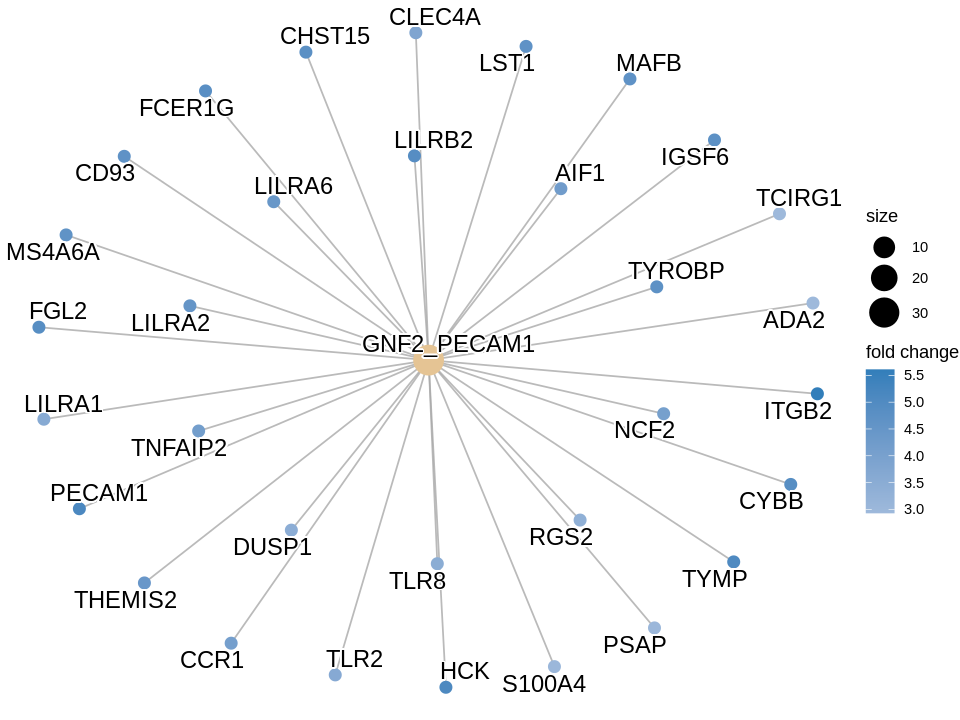

In [44]:
cnetplot(c4, categorySize="pvalue", color.params = list(foldChange=geneList), showCategory = c("GNF2_PECAM1"))

Platelet endothelial cell adhesion molecule (PECAM-1) is a cell-cell adhesion protein found on endothelial cells, platelets, macrophages and Kupffer cells, granulocytes, lymphocytes (T cells, B cells, and NK cells), megakaryocytes, and osteoclasts.Going to the literature, this gene has been studied in the cancer field. Specifically, [one study](https://doi.org/10.1073/pnas.1004654107) found that PECAM-1 in the tumor microenvironment drives advanced metastatic progression of tumor cells. [Another](https://doi.org/10.1023/A:1009092107382) found that an antibody against murine PECAM-1 inhibits tumor angiogenesis in mice.

We may find promising cancer treatment targets by looking at the genes in this gene set. The PECAM1 neighborhood identified with GSEA may represent a network of genes that are involved in regulation of the the tumor microenvironment to make the area more susceptible to tumor invasion. These genes may be worth investigating in future studies and specifically targeting in future cancer treatment development. The last thing we will do is go back to Loupe Browser to visualize the expression of these genes in our tissue.

In [45]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 22.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.20.so;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] org.Hs.eg.db_3.19.1    AnnotationDbi_1.66.0   IRanges_2.38.1        
 [4] S4Vectors_0.42.1       Biobase_2.64.0         BiocGenerics_0.50.0   
 [7] forcats_1.0.